In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NormalOutput

from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import NSTransformerEstimator

2022-11-14 22:26:47.623986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = NSTransformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[4],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
#         distr_output=NormalOutput(),
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(gpus="1", max_epochs=50, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=0,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_34976/464979933.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_34976/464979933.py'                         │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/gluonts/torch/model/estimator.py:243 in   │
│ train                                                                                            │
│                                                                                                  │
│   240 │   │   ckpt_path: Optional[str] = None,                                                   │
│   241 │   │   **kwargs,                                                                          │
│   242 │   ) -> PyTorchPredictor:                                                                 │
│ ❱ 243 │   │   return self.train_model(                                                           │
│   244 │   │   │   training_data,                                                                 │
│   245 │   │   │   validation_data,                                                               │
│   246 │   │   │   num_workers=num_workers,                                                       │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/gluonts/torch/model/estimator.py:218 in   │
│ train_model                                                                                      │
│                                                                                                  │
│   215 │   │   )                                                                                  │
│   216 │   │                                                                                      │
│   217 │   │   logger.info(f"Loading best model from {checkpoint.best_model_path}")               │
│ ❱ 218 │   │   best_model = training_network.load_from_checkpoint(                                │
│   219 │   │   │   checkpoint.best_model_path                                                     │
│   220 │   │   )                                                                                  │
│   221                                                                                            │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:137 in   │
│ load_from_checkpoint                                                                             │
│                                                                                                  │
│   134 │   │   │   pretrained_model.freeze()                                                      │
│   135 │   │   │   y_hat = pretrained_model(x)                                                    │
│   136 │   │   """                                                                                │
│ ❱ 137 │   │   return _load_from_checkpoint(                                                      │
│   138 │   │   │   cls,                                                                           │
│   139 │   │   │   checkpoint_path,                                                               │
│   140 │   │   │   map_location,                                                                  │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:158 in   │
│ _load_from_checkpoint                                      

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 5457.58it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
agg_metrics

{'MSE': 2236509.168963794,
 'abs_error': 8324822.379784622,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6698150047439067,
 'MAPE': 0.08691797733896235,
 'sMAPE': 0.09759165937855493,
 'MSIS': 5.569897501694887,
 'QuantileLoss[0.1]': 3546676.8417349765,
 'Coverage[0.1]': 0.07493324432576769,
 'QuantileLoss[0.2]': 5565987.262607762,
 'Coverage[0.2]': 0.16596202343865896,
 'QuantileLoss[0.3]': 6942721.682276855,
 'Coverage[0.3]': 0.2651869158878505,
 'QuantileLoss[0.4]': 7852264.925932953,
 'Coverage[0.4]': 0.3690847055333037,
 'QuantileLoss[0.5]': 8324822.418652334,
 'Coverage[0.5]': 0.47411363299213766,
 'QuantileLoss[0.6]': 8340378.741592136,
 'Coverage[0.6]': 0.5701305444296099,
 'QuantileLoss[0.7]': 7810405.163447293,
 'Coverage[0.7]': 0.6769210799584632,
 'QuantileLoss[0.8]': 6711281.096624529,
 'Coverage[0.8]': 0.7819685506601394,
 'QuantileLoss[0.9]': 4796936.551227636,
 'Coverage[0.9]': 0.883900756564308

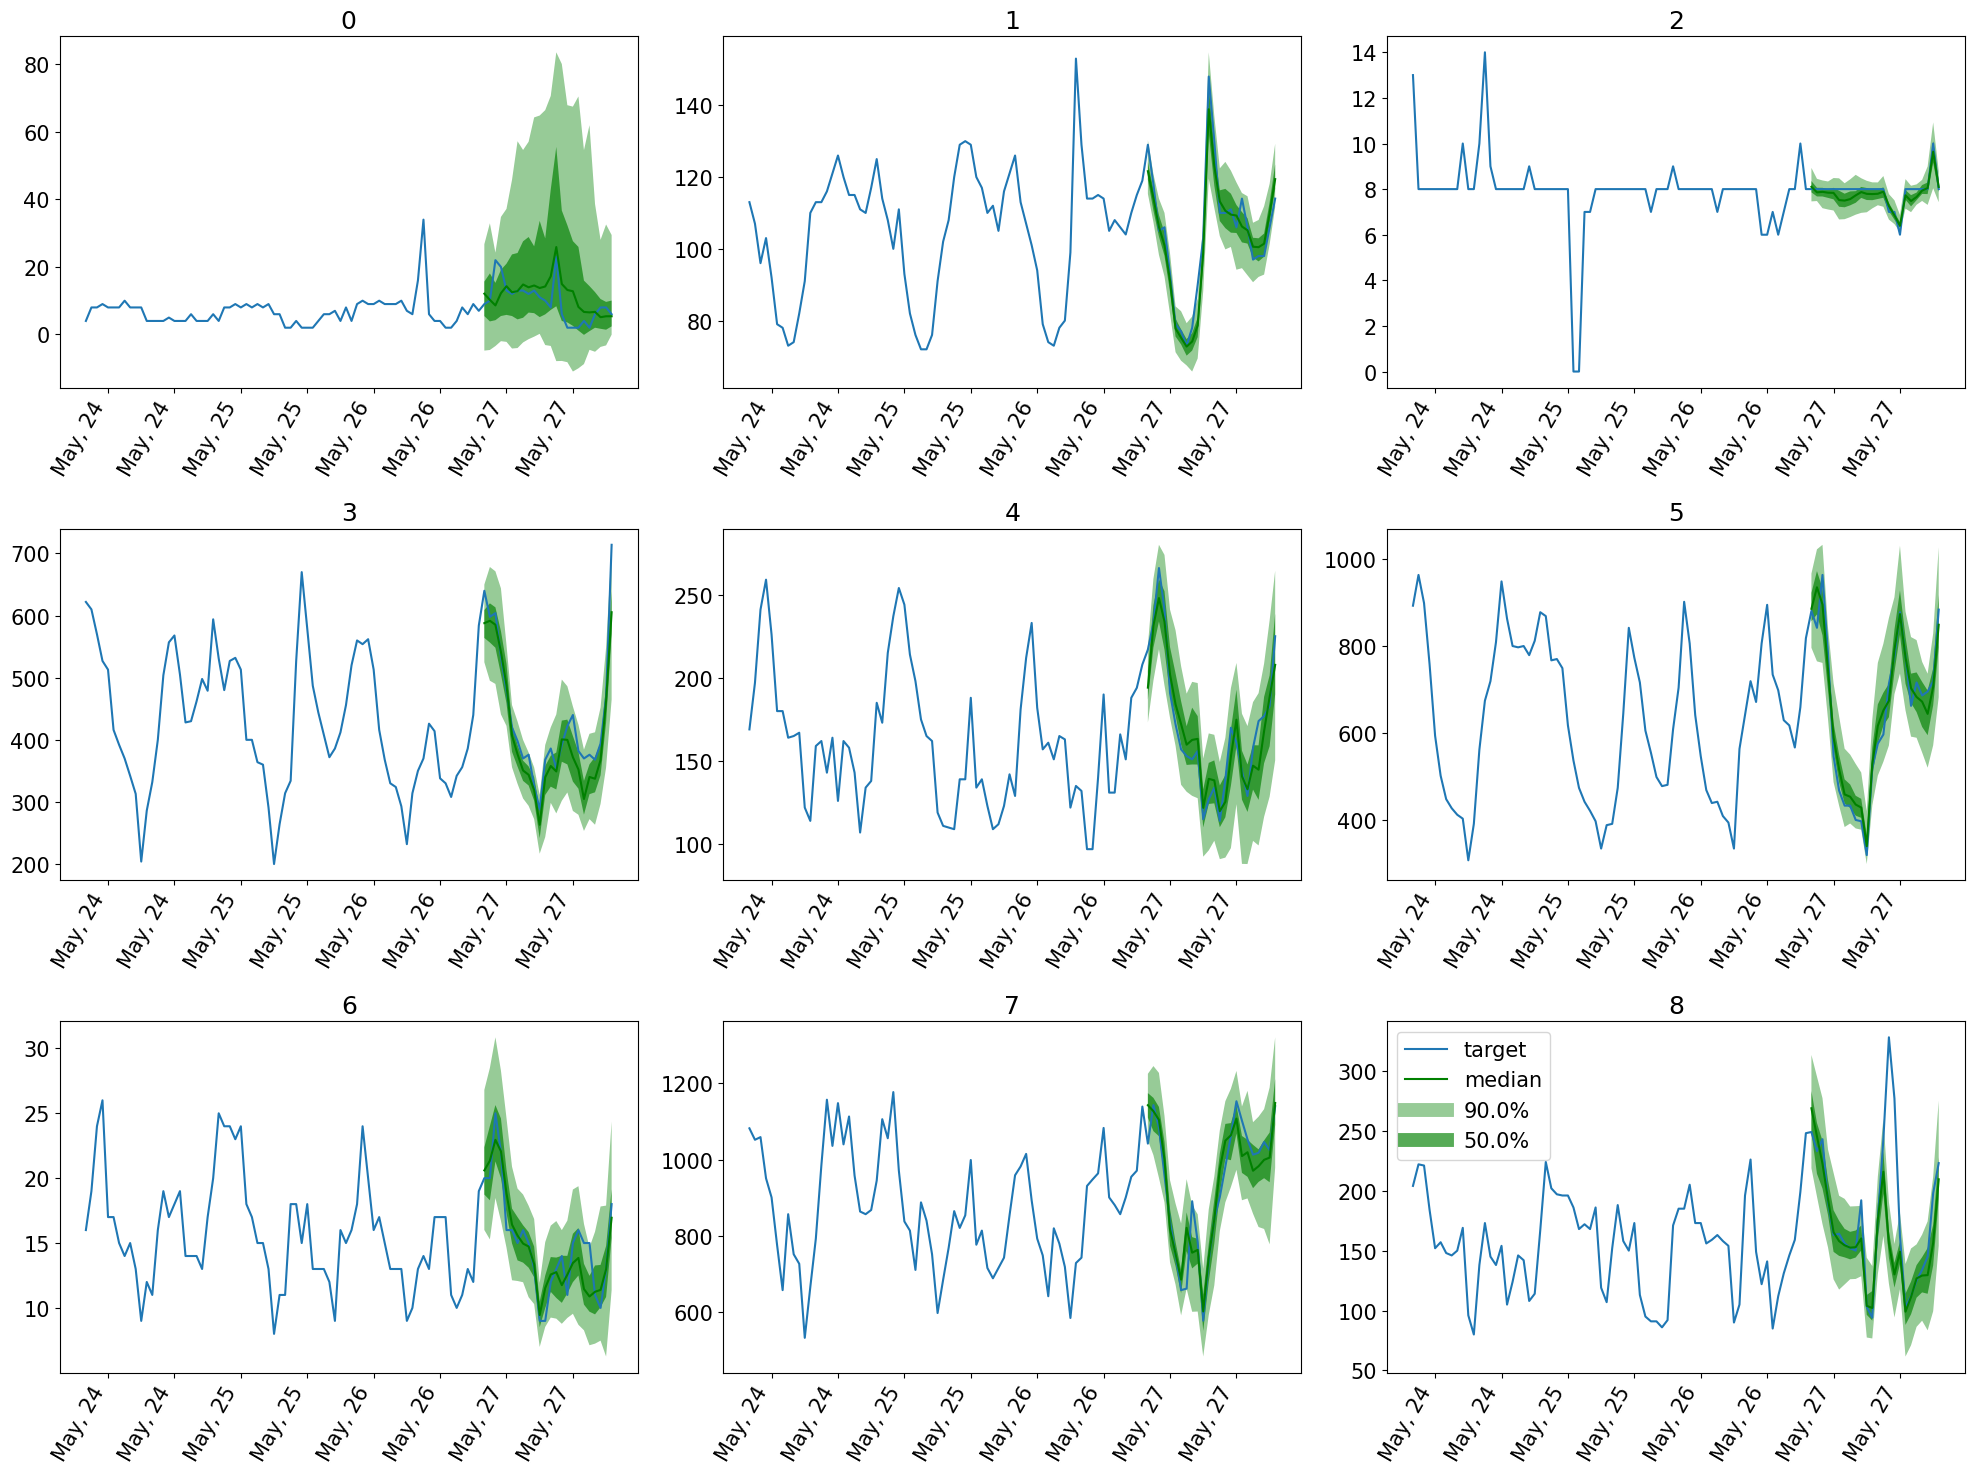

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

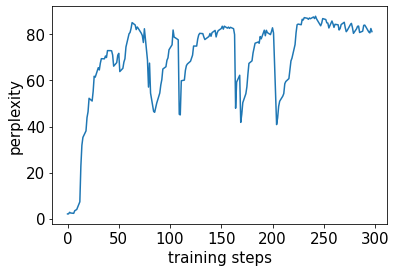

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

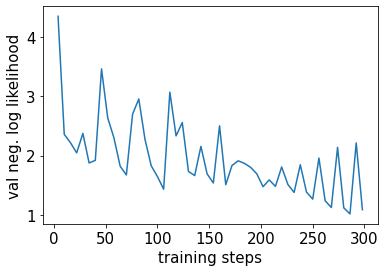

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

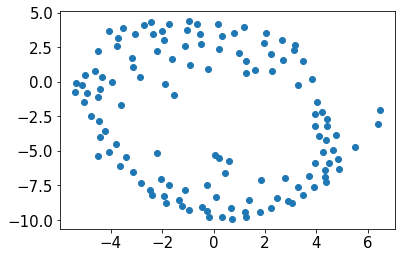

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)